In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import normalize, MinMaxScaler

In [11]:
mitbih_dir = 'mitbih_database/';

# Map the beat type to a unique index. 
beatTypes = {
    'N': 0, 
    'L': 1, 
    'R': 2, 
    'A': 3, 
    'V': 4
}

In [20]:
file_nums = np.append(np.arange(100,125),np.arange(200,235))


numBeats_saved = 0;
numBeats_all = 0;

# 99.7 % of beats are shorter than this length. See histogram below. 
# Let's only use beats shorter than that, so we are't padding the rest of the beats with an excessive number of zeros. 
beatLen_cuttoff = 700; 


beats_list = np.zeros((100000,beatLen_cuttoff+1));
beatLen_dist = np.zeros(120000,);



for fNum in file_nums:
    HB_signal_file = '%s%i.csv'%(mitbih_dir,fNum);
    HB_info_file = '%s%iannotations.txt'%(mitbih_dir,fNum);
    if os.path.exists(HB_signal_file): # A few of the file numbers are not included in the data base. 
        HB_info = pd.read_table(HB_info_file, delim_whitespace=True, engine='python');
        HB_info = drop_rows(HB_info)
        HB_signal = np.loadtxt(HB_signal_file,skiprows =1, delimiter=',');
        HB_signal[:,1] = HB_signal[:,1] - np.median(HB_signal[:,1])
        len_info = len(HB_info);
        for ii in range(1,len_info-1):
            beat_type = HB_info['#'].iloc[ii];
            
            
            # determine when the beat starts and keep a little bit into the next beat. 
            # This window can be adjusted.  
            start = int(HB_info['Sample'].iloc[ii] - (HB_info['Sample'].iloc[ii]-HB_info['Sample'].iloc[ii-1])*1  )
            end  = int( (HB_info['Sample'].iloc[ii+1] - HB_info['Sample'].iloc[ii])/3 + HB_info['Sample'].iloc[ii] )
            
            # Extract the beat from the full heart rate signal.  
            beat = HB_signal[start:end,1].reshape(-1,1)
            
            
            # how long is the beat. 
            beatLen = len(beat);
            
            # build a distribution of the length of all beats.
            # So that we can determine an appropriate cuttoff length. 
            beatLen_dist[numBeats_all] = beatLen;
            numBeats_all += 1;
            
            # Store beats that arn't longer than the cuttoff 
            # and are one of the types we want to analyze.  
            if len(beat) < beatLen_cuttoff and beat_type in beatTypes:
                scaler = MinMaxScaler(feature_range=(0, 1))
                scaler = scaler.fit(beat)
                beat_norm = scaler.transform(beat)
                beats_list[numBeats_saved, :beatLen] = beat_norm[:,0];
                beats_list[numBeats_saved,-1] = beatTypes[beat_type];
                numBeats_saved += 1;

# Save the extracted beats for latter use. 
np.savetxt('beats_list.csv',beats_list[:numBeats_saved,:],delimiter=',')      #
            
        

Percent of beats longer than 700: 0.34%


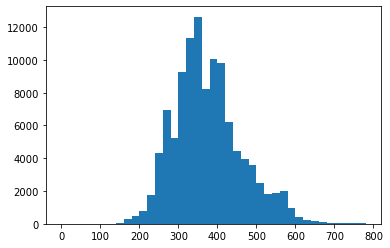

In [19]:
beatLen_dist = beatLen_dist[:numBeats_all];
bins = np.arange(0,800,20);
#print('Mean length of a beat: %i '%np.median(beatLen_dist))

plt.hist(beatLen_dist, bins=bins);

beatFrac = sum(beatLen_dist > beatLen_cuttoff)/len(beatLen_dist)*100;
print('Percent of beats longer than 700: %0.2f%%'%beatFrac);

In [14]:
#since rows with these labels don't correspond to an R-peak we want to drop them. 
def drop_rows(HB_info):
    drop_symbols = ['+','~','!','|',']','[']
    for symb in drop_symbols:
        HB_info = HB_info[HB_info['#'] != symb]
    return HB_info;
